# *Faraday Rotation* | Lab-Session #2
## Mar-01-2021 13:45

This jupyter notebook is a used to collect and analyse data during today's lab session

In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as consts
import os
from csvlib import *
from scipy.optimize import curve_fit

# Display mpl in notebook format
%matplotlib inline

# Data Collection

In [2]:
# open CSV files to numpy array
csvs = list_csv(PRINT='True')   # Lists CSV files in a given directory
DATA = pd.read_csv(csvs[1])     # Gets the CSV file as a Pandas Data Frame
data = DATA.to_numpy().T        # Gets data as a numpy array
DATA                            # Prints pretty PANDAS data frame

List of .csv files in .
	 0 : DC_VERDET_ROD.csv
	 1 : DC_VERDET_ROD_edited.csv


,I [mA],I_std [_A],V0 [mV],V0_std [_V],V1 [mV],V1_std [_V]
0,300.95,11,75.142,206,75.895,201
1,600.33,13,75.265,199,76.855,131
2,900.13,27,75.314,148,77.818,103
3,1200.10,118,75.273,96,78.665,125
4,1499.90,111,75.458,107,79.573,113
5,1799.50,156,75.686,113,80.819,121
6,2097.60,230,75.764,77,81.860,96


# Data Analysis

In [3]:
# parameters from LAB on malus
theta = -0.068
theta_std = 0.00305
V0 = 0.201
V0_std = 0.00058

# parameters from setup
L = 10.174*1e-2
L_std = 0.005*1e-2
k = 0.011


# magnetic field from current data
B = k*data[0]*1e-3
B_std = k*data[1]*1e-6

# voltage from data
Vi = data[2]*1e-3
Vi_std = data[3]*1e-6
Vf = data[4]*1e-3
Vf_std = data[5]*1e-6

# angle of polarizer
alpha = 40*np.pi/180
alpha_std = 0.05*np.pi/180


#print(data[0])

phi = -alpha - theta + np.arccos(np.cos(alpha+theta)*np.sqrt(Vf/Vi))

df_dangle = -1-np.sqrt(Vf/Vi)*np.sin(alpha+theta)/np.sqrt(np.sqrt(Vf/Vi)-np.cos(alpha+theta)**2)
print(df_dangle)
df_dVi = 0.5*np.cos(alpha+theta)*np.sqrt(Vf/(Vi**3-Vf*Vi**2*np.cos(alpha+theta)**2))
df_dVf = df_dVi*np.sqrt(Vi**2/Vf)

sigma_phi = np.sqrt((df_dangle*(alpha_std**2+theta_std**2))**2+(Vi_std*df_dVi)**2+(Vf_std*df_dVf)**2)
print(sigma_phi)


[-1.99784195 -1.995556   -1.9931804  -1.99097888 -1.98929121 -1.98703335
 -1.98499778]
[0.00197341 0.00189892 0.00143924 0.00098989 0.00109521 0.00117764
 0.00082812]


In [4]:
Verd = np.abs(phi/(B*L))
Verd_std = np.abs(Verd*np.sqrt((sigma_phi/phi)**2+(L_std/L)**2))
print(Verd)
print(Verd_std)

[20.44381333 21.6609786  22.8028777  23.25019713 22.56847434 23.47828039
 23.98132969]
[5.85919811 2.82640366 1.42875541 0.73712036 0.65254893 0.58487373
 0.35296202]


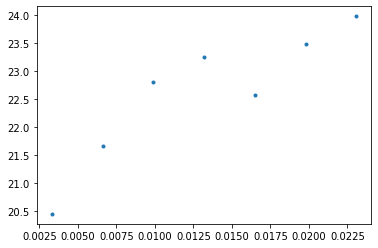

In [5]:
plt.plot(B,Verd,'.')


22.597993026816198


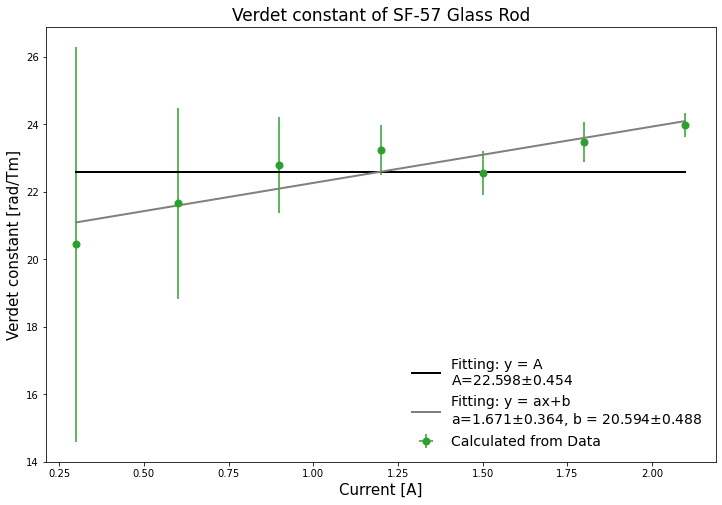

In [24]:
# Data fitting

# x = theta
# x_err = error from scale on polarizer 
# xlin = equidistanced x array to plot the fit 

# y = voltage
# y_err = std dev of voltage (from oscilloscope)

x = data[0]*1e-3
x_err = data[1]*1e-6

Npts = 1000
xlin = np.linspace(x[0],x[-1],Npts)

y = Verd
y_err = Verd_std# from micro to mili volts


# Fit data with a line
def fit(x,a):
    return a+x-x
def line(x,a,b):
    return a*x+b

#params, pcov = curve_fit(fit,x,y,p0=[3.2,1/(17*np.pi),0])

params, pcov = curve_fit(fit,x,y)
params_l, pcov_l = curve_fit(line,x,y)

err_l = [np.sqrt(pcov_l[0][0]),np.sqrt(pcov_l[1][1])]

# Define the figure and plot parameters
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Verdet constant of SF-57 Glass Rod',fontsize=17)
ax.set_xlabel('Current [A]',fontsize=15)
ax.set_ylabel('Verdet constant [rad/Tm]',fontsize=15)

y_avg = fit(x,*params)
y_line = line(x,*params_l)
# Plot the actual elements
ax.errorbar(x,y,yerr = y_err, xerr = x_err, color = 'C2',ms = 7, fmt = 'o',label='Calculated from Data')
ax.plot(xlin,fit(xlin,*params), color = 'black', lw = 2, label='Fitting: y = A\nA=%5.3f$\pm$%5.3f'%(params,np.sqrt(pcov)))
ax.plot(xlin,line(xlin,*params_l), color = 'grey', lw = 2,
        label='Fitting: y = ax+b\na=%5.3f$\pm$%5.3f'%(params_l[0],err_l[0])+', b = %5.3f$\pm$%5.3f'%(params_l[1],err_l[1]))

ax.legend(fontsize = 14,loc='lower right',frameon=False)
print(np.sum(Verd)/len(Verd))
# ax.grid()
#fig.savefig("verdet_DC.png",dpi=300)
slope = 1.671

In [8]:
40*np.pi/180

0.6981317007977318

In [9]:
0.05*np.pi/180

0.0008726646259971648

In [25]:
# fitting w/ fos lab
# Error analysis
def chi_s(x,y,y_err,est):
    chi2 = 0
    for i in range(len(x)):
        chi2+= (y[i]-est(x[i]))**2/y_err[i]**2
        
    return chi2

def a_cu(x,y,est):
    chi2 = 0
    for i in range(len(x)):
        chi2+= (y[i]-est(x[i]))**2
        
    return chi2/(len(x)-2)

def a_m(x,y,est):
    ss = 0;
    for xi in x: 
        ss+=xi**2
        
    s = 0
    for xi in x:
        s+=xi
    s*=s
    delta = len(x)*ss - s
        
    return a_cu(x,y,est)*(len(x)/delta)**0.5

def a_c(x,y,est):
    ss = 0;
    for xi in x: 
        ss+=xi**2
        
    s = 0
    for xi in x:
        s+=xi
    s*=s
    delta = len(x)*ss - s
        
    return a_cu(x,y,est)*(ss/delta)**0.5

fitt = lambda x: m*x + b

# Get fit
m, b = np.polyfit(x, y, 1)
am = a_m(x,y,fitt)
ac = a_c(x,y,fitt)
chi = chi_s(x,y,y_err,fitt)
print(chi)
print(m,am)
print(b,ac)

1.8523122866026074
1.6705397833607039 0.2097702315924166
20.59370087310867 0.281316406318585


In [28]:
#pearson correlation coefficient
avg = np.sum((y-y_avg)**2)
line = np.sum((y-y_line)**2)
rsq = np.sqrt((avg-line)/avg)
print(rsq)
#DOF = N-2 = 5

0.8990812431881828


In [29]:
chi2_line = np.sum(((y-y_avg)/y_err)**2)
chi2_avg = np.sum(((y-y_line)/y_err)**2)

In [30]:
print(chi2_line,chi2_avg)

18.67615929142036 1.852312257014362
